## Ireland Covid-19 datasets

* https://data.gov.ie/dataset?q=covid&sort=score+desc%2C+metadata_created+desc
* https://www.hpsc.ie/a-z/respiratory/coronavirus/novelcoronavirus/casesinireland/epidemiologyofcovid-19inireland/
* https://covid19ireland-geohive.hub.arcgis.com/

In [27]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
sns.set_context('talk')
pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
import geopandas as gpd

## LaboratoryLocalTimeSeriesHistoricView

In [28]:
labs = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/f6d6332820ca466999dbd852f6ad4d5a_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}')
labs['date'] = pd.to_datetime(labs['Date_HPSC'], infer_datetime_format=True)
labs[-5:]

,Date_HPSC,Hospitals,TotalLabs,NonHospitals,Positive,PRate,Test24,Test7,Pos7,PosR7,FID,date
204,2020/10/08 11:00:00+00,447753,1287332,839579,44133,3.4,15880,91823,3890,4.2,205,2020-10-08 11:00:00
205,2020/10/09 11:00:00+00,452263,1303854,851591,44990,3.5,16522,95672,4289,4.5,206,2020-10-09 11:00:00
206,2020/10/10 11:00:00+00,456464,1319488,863024,45937,3.5,15634,97685,4626,4.7,207,2020-10-10 11:00:00
207,2020/10/11 11:00:00+00,459414,1327486,868072,46519,3.5,7998,94388,4783,5.1,208,2020-10-11 11:00:00
208,2020/10/12 11:00:00+00,462288,1341474,879186,47517,3.5,13988,96210,5278,5.5,209,2020-10-12 11:00:00


In [29]:
labs['Positive_diff'] = labs.Positive.diff()
labs['Tests_diff'] = labs.TotalLabs.diff()

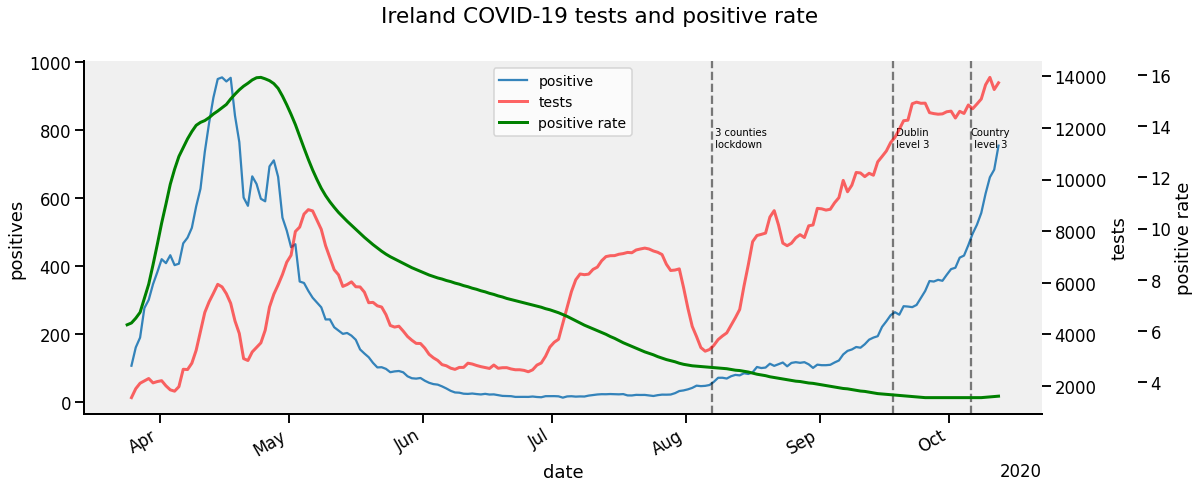

In [30]:
window=7
x=labs.set_index('date').rolling(window).mean()
#print (x[-10:])
x['false_pos'] = x.Tests_diff*0.005


f,ax=plt.subplots(figsize=(17,7))
l1=x.plot(y='Positive_diff',ax=ax,legend=False,alpha=.9)
ax1=ax.twinx()
x.plot(y='Tests_diff',ax=ax1,color='red',lw=3,legend=False,alpha=.6)
ax.set_ylabel('positives')
ax2=ax.twinx()
#ax2.axis('off')
ax1.set_ylabel('tests')
ax2.set_ylabel('positive rate')
ax2.spines["right"].set_position(("axes", 1.1))
ax.set_facecolor('#f0f0f0')
x.plot(y='PRate',ax=ax2,color='green',lw=3,legend=False)
#error on positives based on 1% false positive rate in testing
#ax.fill_between(x.index, x.Positive_diff, x.Positive_diff-x.false_pos, alpha=0.3)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['positive','tests','positive rate'],loc=9,fontsize=14)
f.suptitle('Ireland COVID-19 tests and positive rate')

for date,text in [('2020-08-07',' 3 counties\n lockdown'),('2020-09-18',' Dublin\n level 3'),('2020-10-06','Country\n level 3'),]:
    ax.axvline(date,0,1000,linestyle='--',alpha=0.5,c='black')
    ax.text(date,750,text,fontsize=10)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
sns.despine()
plt.tight_layout()
f.savefig('ireland_covid_tests_prate.jpg',dpi=150)

<AxesSubplot:xlabel='Tests_diff', ylabel='Positive_diff'>

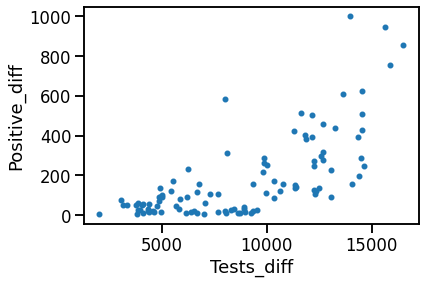

In [31]:
x=labs[(labs.date>'2020-07-01')]
x.plot('Tests_diff','Positive_diff',kind='scatter')

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


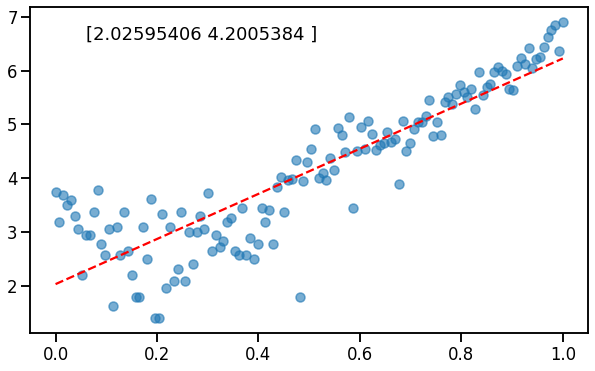

In [32]:

def fit_cases(y):
    from scipy.optimize import curve_fit 
    x = np.linspace(0, 1, num = len(y)) 
    #x = range(len(y))
    def func0(x, a, b): 
        return a+b*x
    def func1(x, a, b): 
        return a+np.exp(b*x)

    param, param_cov = curve_fit(func0, x, y) 
    f0 = func0(x,param[0],param[1])
    #param, param_cov = curve_fit(func1, x, y) 
    #f1 = func1(x,param[0],param[1])
    #print (param)

    f,ax=plt.subplots(figsize=(10,6))
    plt.scatter(x,y,alpha=0.6)
    plt.plot(x,f0,'--', color ='red')
    #plt.plot(x,f1,'--', color ='green',lw=4)
    plt.text(.1,.9,param,transform=ax.transAxes)
    
y = labs[(labs.date>'2020-06-01')].Positive_diff
y = np.log(y)
fit_cases(y)


## Covid19CountyStatisticsHPSCIrelandOpenData

In [33]:
cs = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}')
cs['time'] = pd.to_datetime(cs['TimeStamp'], infer_datetime_format=True)
cs = cs.sort_values(['CountyName','time'])
cs.columns

Index(['OBJECTID', 'ORIGID', 'CountyName', 'PopulationCensus16', 'TimeStamp', 'IGEasting', 'IGNorthing', 'Lat', 'Long', 'UGI', 'ConfirmedCovidCases',
       'PopulationProportionCovidCases', 'ConfirmedCovidDeaths', 'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length', 'time'],
      dtype='object')

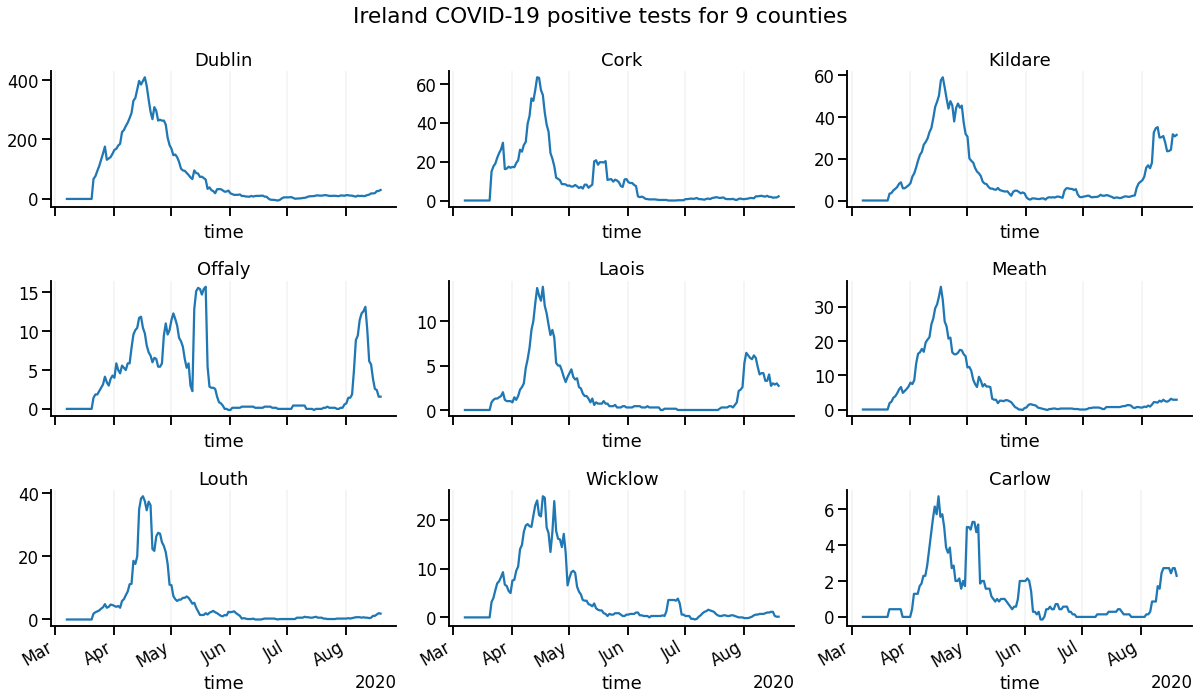

In [34]:
x=cs.set_index('time').rolling(window).mean()
f,ax=plt.subplots(3,3,figsize=(17,10))
axs=ax.flat
grouped = cs.groupby('CountyName')
i=0
for c in ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']:
    ax=axs[i]
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff() 
    x.plot(y='cases',ax=ax,legend=False)
    ax.set_title(c)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(axis='x',color='0.95')
    #ax1=ax.twinx()
    x.plot(y='ConfirmedCovidDeaths',ax=ax1,legend=False,color='red')
    if i>5:
        ax.xaxis.set_major_formatter(formatter)
    else:
        ax.set_xticklabels([])
    i+=1
sns.despine()
f.suptitle('Ireland COVID-19 positive tests for 9 counties')
plt.tight_layout()
f.savefig('ireland_covid_tests_bycounty.jpg',dpi=150)


## single counties plot

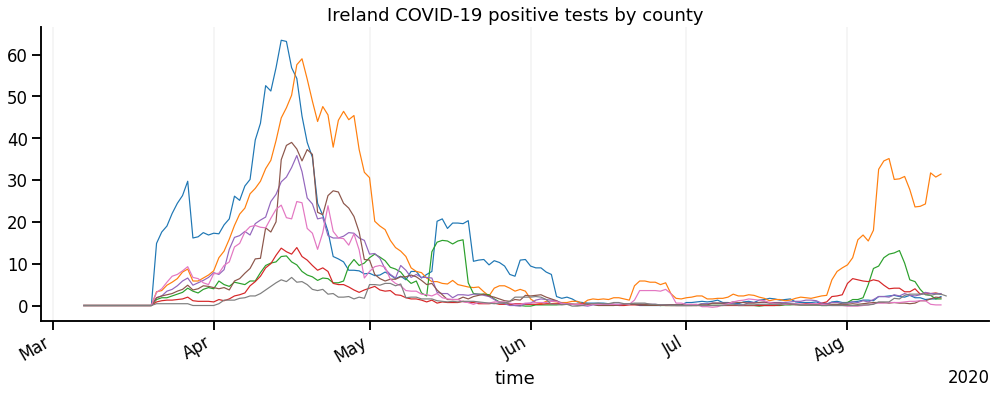

In [57]:
f,ax=plt.subplots(1,1,figsize=(17,6))
colors=sns.color_palette()
counties = cs.CountyName.unique()
selection = ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']
i=0
lines=[]
for c in selection:
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff()
    if c == 'Dublin':
        continue
    if c in selection:
        clr=colors[i]
        i+=1
    else:
        clr='#d0d0e1'
    a=x.plot(y='cases',ax=ax,legend=False,c=clr,lw=1.2)    
    
ax.set_title('Ireland COVID-19 positive tests by county')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(axis='x',color='0.95')
#ax.legend(lines,selection,loc=9,fontsize=14)

sns.despine()


## CovidStatisticsProfileHPSCIrelandOpenData

In [72]:
daily = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={"latestWkid":3857,"wkid":102100}')
daily['date'] = pd.to_datetime(daily['Date'], infer_datetime_format=True)
daily['hospitalised_diff'] = daily.HospitalisedCovidCases.diff()

In [73]:
ds = daily.groupby('date').sum().reset_index()

In [74]:
cols=['date','ConfirmedCovidCases','HospitalisedCovidCases','hospitalised_diff','ConfirmedCovidDeaths']
x=ds[cols]
x = x[(x.date>'2020-04-30')]

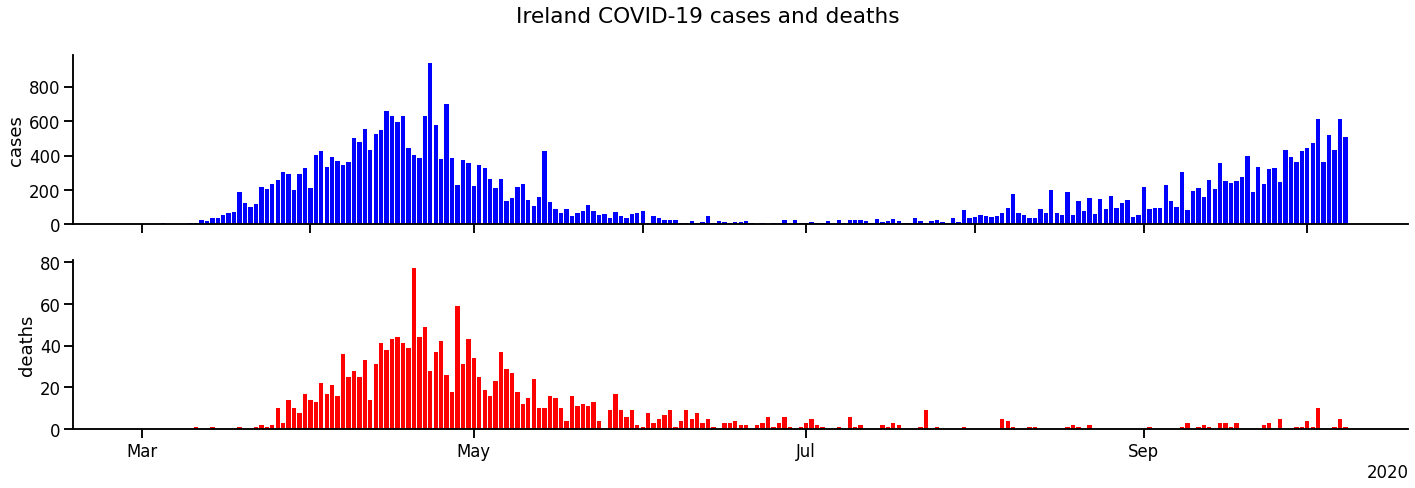

In [75]:
f,axs=plt.subplots(2,1,figsize=(20,7))
ax1=axs[0]
#ds.plot(x='date',y='ConfirmedCovidCases',ax=ax1,lw=2,legend=False,alpha=0.8,kind='bar')
ax1.bar(ds.date, ds.ConfirmedCovidCases,color='blue',width=.8)
ax1.set_ylabel('cases')
ax1.xaxis.set_ticklabels([])

ax2=axs[1]
#ds.plot(x='date',y='hospitalised_diff',ax=ax1,lw=3,legend=False,color='green')
#ds.plot(x='date',y='ConfirmedCovidDeaths',ax=ax2,legend=False,color='red',kind='bar')
ax2.bar(ds.date, ds.ConfirmedCovidDeaths,color='red')
ax2.set_ylabel('deaths')
ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)

#ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['confirmed cases','hospitalised','deaths'],loc=1,fontsize=14)
f.suptitle('Ireland COVID-19 cases and deaths')
plt.tight_layout()
sns.despine()
f.savefig('ireland_covid_hosp_deaths.jpg',dpi=150)

In [ ]:
hosp = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/fe9bb23592ec4142a4f4c2c9bd32f749_0.csv?outSR={%22latestWkid%22:4326,%22wkid%22:4326}')

In [44]:
idf = gpd.read_file('map_data/Covid19CountyStatisticsHPSCIreland.shp')

In [48]:
time='2020-02-27'
g=idf[idf.TimeStamp==time]

In [ ]:
fig, ax = plt.subplots(1, figsize=(9,9))
g.plot(column='Population', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.2',legend=True)
ax.axis('off')